# Prediction of fraudulent transaction made

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [3]:
# Splitting Train-Test data
from sklearn.model_selection import train_test_split

In [4]:
# For Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [5]:
# For showing Progress Bar
from tqdm.notebook import tqdm

In [6]:
# Models
import optuna
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

In [8]:
#used for plotting purpose
def outlier_viz(col):
    import random
    color = random.choice(['r', 'g', 'b'])
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    sns.distplot(col, ax=ax[0], color=color)
    sns.boxplot(col, ax=ax[1], color=color)
    plt.suptitle('Distribution & Boxplot for Outlier Detection')
    fig.show()
    return None

In [11]:
#used for the printing purpose
def my_print(s):
    a = 4
    for i in s:
        a+=1
    return print('-' * a + '\n' + '| ' + s + ' |' + '\n' + '-' * a)

In [12]:
#To read the csv data file
df = pd.read_csv('Fraud.csv')

# Given data dictionary

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [13]:
df.head() #to view only the 1st 5 rows of the data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [14]:
df.info() #to view all the information related to this data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [15]:
df.describe() #used to view all the statistical details

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


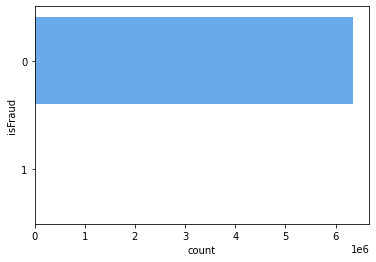

In [16]:
sns.countplot(y = df['isFraud'], palette='cool'); #to count the observation of each value of isFraud column

How did you select variables to be included in the model?

-Using the correlation heatmap.

-We just need to check if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the isFraud Attribute.

Target Variable is highly Imbalanced.

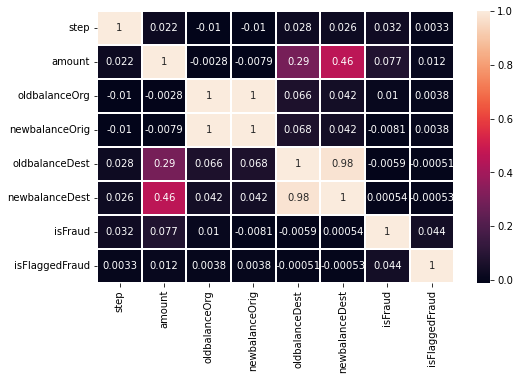

In [17]:
#To see correlation between each and every column.
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), linewidth=0.2, annot=True);

In [18]:
df['isFraud'].value_counts() #count the number of values of isFraud column

0    6354407
1       8213
Name: isFraud, dtype: int64

In [19]:
fraud = df[df['isFraud'] == 1] #when isFraud value is 1 then there is a fraud

In [20]:
df.isnull().sum() #check if there a null value for each column

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Splitting Numerical and Categorical Data

In [21]:
#categorical data(the datatype of this starts with 'o')
cat = [i for i in df.drop('isFraud', axis=1).columns if df[i].dtypes == 'O']
cat

['type', 'nameOrig', 'nameDest']

In [22]:
#numerical data(all the data other than categorical)
num = [i for i in df.drop('isFraud', axis=1).columns if df[i].dtypes != 'O']
num

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud']

Categorical Data

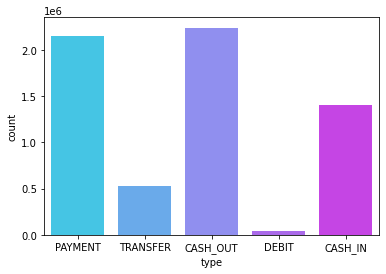

In [23]:
sns.countplot(df['type'], palette='cool'); #to count observation of each type of transaction done

In [24]:
df['nameOrig'].nunique(), df['nameDest'].nunique() #to find the total number of unique value in nameOrig and nameDest column

(6353307, 2722362)

<AxesSubplot:xlabel='step', ylabel='Density'>

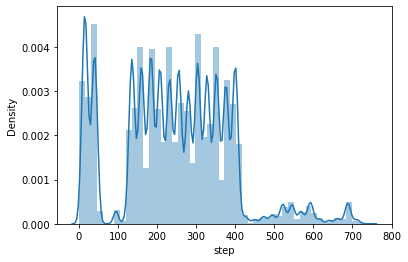

In [25]:
sns.distplot(df['step'])  #to show the distribution of each step value with the density distribution

<AxesSubplot:xlabel='amount', ylabel='Density'>

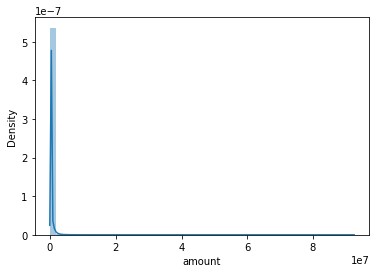

In [26]:
sns.distplot(df['amount'])  #to see which range of amount is most used for transaction

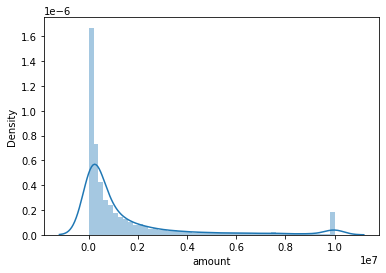

In [27]:
sns.distplot(fraud['amount']);  #to see for which range of amount the most fraud is made

We can see that fraud is only when amount is low.

In [28]:
df.dtypes #to see the data type of each column

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [29]:
#to get dummy column for each type of transaction
types = pd.get_dummies(df['type'], prefix='type', drop_first=True)
types.head()

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0


In [30]:
df['nameOrig'] = label.fit_transform(df['nameOrig']) #used to scale the nameOrig column
df['nameDest'] = label.fit_transform(df['nameDest']) #used to scale the nameDest column

In [31]:
df[['nameOrig', 'nameDest']]

,nameOrig,nameDest
0,757869,1662094
1,2188998,1733924
2,1002156,439685
3,5828262,391696
4,3445981,828919
...,...,...
6362615,5651847,505863
6362616,1737278,260949
6362617,533958,108224
6362618,2252932,319713


In [32]:
df = pd.concat([df, types], axis=1)  #add all the types of transaction columns to the main dataframe
df = df.drop('type', axis=1) #remove the type column from the dataframe
df.head() #show the 1st 5 lines of the dataframe

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,1,0


In [33]:
X = df.drop('isFraud', axis=1)  #drop the isFraud column and store it in X
y = df['isFraud']  #store the isFraud column to y

In [34]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=24)  #from training and testing purpose

In [35]:
N_SPLITS = 2  #increasing N_SPLITS to remove error due to randomness

lgbm_preds = []
xgb_preds = []
catb_preds = []

prob = []

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)  #to assign the number of folds

for fold, (train_id, test_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):

    my_print(f'fold {fold + 1}')

    X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
    X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]
    
    #assign the classifier function to each model
    lgbm_model = lgbm.LGBMClassifier()  
    xgb_model  = xgb.XGBClassifier()
    catb_model = catb.CatBoostClassifier(verbose=0)
    
    #fit the training values to the models
    lgbm_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    catb_model.fit(X_train, y_train)
    
    #print the accuracy of traing and validation for each model used
    my_print(f'Training Accuracy   :- {(lgbm_model.score(X_train, y_train)*100).round(2)}% | {(xgb_model.score(X_train, y_train)*100).round(2)}% | {(catb_model.score(X_train, y_train)*100).round(2)}%')
    my_print(f'Validation Accuracy :- {(lgbm_model.score(X_valid, y_valid)*100).round(2)}% | {(xgb_model.score(X_valid, y_valid)*100).round(2)}% | {(catb_model.score(X_valid, y_valid)*100).round(2)}%')
    
    prob1, prob2, prob3 = lgbm_model.predict_proba(X_test), xgb_model.predict_proba(X_test), catb_model.predict_proba(X_test)
    prob.append((prob1 + prob2 + prob3) / 3)
my_print('Model Trained !!!')

  0%|          | 0/2 [00:00<?, ?it/s]

----------
| fold 1 |
----------
[12:35:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---------------------------------------------------
| Training Accuracy   :- 99.88% | 99.99% | 100.0% |
---------------------------------------------------
---------------------------------------------------
| Validation Accuracy :- 99.88% | 99.98% | 99.98% |
---------------------------------------------------
----------
| fold 2 |
----------
[12:53:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
--

In [36]:
#to find the predicted value 
final = [[0,0]]
for i in range(N_SPLITS):
    final = final + prob[i]
    
final = final/N_SPLITS
y_pred = pd.Series([np.argmax([i]) for i in final])

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_print(f'Test Accuracy:- {accuracy_score(y_test, y_pred)*100}%')  #print the accuracy of the test value

--------------------------------------
| Test Accuracy:- 99.97673914205154% |
--------------------------------------


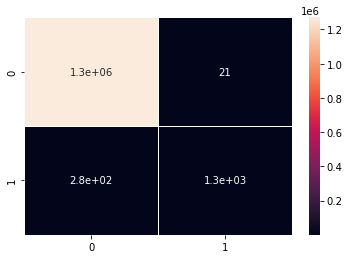

In [38]:
#developed the confusion matrix to show the performance of the classification algorithm
sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=0.5, annot=True); 

# CONCLUSION

What are the key factors that predict fraudulent customer?

1.The source of request is secured or not ?

2.Is the name of organisation asking for money is legit or not ?

3.Transaction history of vendors.

What kind of prevention should be adopted while company update its infrastructure?

1.Use smart vertified apps only.

2.Browse through secured websites.

3.Use secured internet connections (USE VPN).

4.Keep your mobile and laptop security updated.

5.Don't respond to unsolicited calls/SMS(s/E-mails.

6.If you feel like you have been tricked or security compromised, contact your bank immidiately.

Assuming these actions have been implemented, how would you determine if they work?

1.Bank sending E-statements.

2.Customers keeping a check of their account activity.

3.Always keep a log of your payments.